In [21]:
import pandas as pd
import seaborn as sb
import numpy as np
import math
import matplotlib.pyplot as plt

In [22]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
df.head()

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4


In [23]:
df['experiment_name'].unique()

array(['whisper-small-tira', 'whisper-small-tira-all',
       'whisper-small-tira-all-clean',
       'whisper-small-tira-all-clean-ewc-lambda-1',
       'whisper-small-tira-all-clean-lid-alpha-0.2',
       'whisper-small-tira-all-clean-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-all-ewc-lambda-1',
       'whisper-small-tira-all-lid-alpha-0.2',
       'whisper-small-tira-all-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-all-long-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng', 'whisper-small-tira-eng-cs',
       'whisper-small-tira-eng-cs-20-80-large',
       'whisper-small-tira-eng-cs-20-80-large-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-large-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-20-80-small',
       'whisper-small-tira-eng-cs-20-80-small-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-small-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-50-50',
       'whisper-small-tira-eng-cs-50-50-ewc-lambda-1',
       'whisper-

In [24]:
# get more detailed colnames
get_metric = lambda s: 'cer' if s.endswith('cer') else 'wer' if s.endswith('wer') else ''
df['metric']=df['tag'].apply(get_metric)
df['metric'].value_counts()

metric
       10180
cer     1533
wer     1533
Name: count, dtype: int64

In [25]:
df

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,NaN,6288,eval_steps_per_second,0.049000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,6,
13242,NaN,7336,eval_steps_per_second,0.038000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,7,
13243,NaN,8384,eval_steps_per_second,0.172000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,8,
13244,NaN,9432,eval_steps_per_second,0.034000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,9,


In [26]:
df['epoch']=0
epoch_mask = df['tag'].str.contains('epoch')
for i, row in df[epoch_mask].iterrows():
    step_mask = df['step']==row['step']
    exp_mask = df['experiment_name']==row['experiment_name']
    df.loc[step_mask & exp_mask, 'epoch'] = int(row['value'])
df

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,NaN,6288,eval_steps_per_second,0.049000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,6,
13242,NaN,7336,eval_steps_per_second,0.038000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,7,
13243,NaN,8384,eval_steps_per_second,0.172000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,8,
13244,NaN,9432,eval_steps_per_second,0.034000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,9,


In [27]:
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split', 'sasoc-cs', 'sasoc-zul', 'sasoc-en', 'nchlt_zul', 'nchlt_eng', 'tira_cs']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
df['dataset'].value_counts()

dataset
sasoc-cs     2520
fl_en        2052
nchlt_zul    1572
Name: count, dtype: int64

In [28]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

In [29]:
df['ewc']=df['ewc_lambda']>0
df['lid_loss']=df['lid_loss_alpha']>0
df['regularization']='none'
df.loc[df['ewc'], 'regularization']='ewc'
df.loc[df['lid_loss'], 'regularization']='lid_loss'
df.loc[df['ewc'] & df['lid_loss'], 'regularization']='ewc+lid_loss'

In [30]:
df['train_data']='tira'
df.loc[df['experiment_name'].str.contains('tira-eng'), 'train_data']='tira-eng'
df.loc[df['experiment_name'].str.contains('tira-eng-50pct'), 'train_data']='tira-eng-50pct'
df.loc[df['experiment_name'].str.contains('tira-eng-cs'), 'train_data']='misc'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-small'), 'train_data']='tira-eng-cs-20-80-small'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-large'), 'train_data']='tira-eng-cs-20-80-large'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-50-50-large'), 'train_data']='tira-eng-cs-50-50'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-clean'), 'train_data']='tira-eng-cs-clean'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-long'), 'train_data']='tira-eng-cs-long'
df.loc[df['experiment_name'].str.contains('tira-all'), 'train_data']='tira-all'
df.loc[df['experiment_name'].str.contains('tira-all-clean'), 'train_data']='tira-all-clean'
df.loc[df['experiment_name'].str.contains('tira-all-long'), 'train_data']='tira-all-long'

df.loc[df['experiment_name'].str.contains('zulu'), 'train_data']='zulu'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng'), 'train_data']='zulu+eng'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng-50pct'), 'train_data']='zulu+eng-50pct'
df.loc[df['experiment_name'].str.contains('zulu-eng-cs'), 'train_data']='zulu-eng-cs'
df.loc[df['experiment_name'].str.contains('zulu-eng-all'), 'train_data']='zulu-eng-all'

df['train_data'].value_counts()

train_data
zulu-eng-cs                2704
zulu+eng                   2500
zulu                       2096
tira-all                    808
misc                        742
zulu-eng-all                729
tira-eng                    712
tira-all-clean              576
tira                        536
tira-eng-cs-long            376
zulu+eng-50pct              376
tira-eng-cs-clean           344
tira-eng-cs-20-80-large     318
tira-eng-cs-20-80-small     270
tira-all-long               159
Name: count, dtype: int64

In [31]:
df.loc[
    df['experiment_name'].str.contains('tira')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'tira-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     2520
tira-cs      2442
fl_en        2052
nchlt_zul    1572
Name: count, dtype: int64

In [32]:
df.loc[
    (df['train_data']=='zulu-eng-all')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'sasoc-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     3012
tira-cs      2442
fl_en        2052
nchlt_zul    1572
Name: count, dtype: int64

In [33]:
df=df.sort_values('step')
for experiment in df['experiment_name'].unique():
    for tag in df['tag'].unique():
        if 'loss' not in tag:
            continue
        loss_mask = df['tag']==tag
        experiment_mask = df['experiment_name']==experiment
        loss_diff = np.diff(df.loc[experiment_mask&loss_mask, 'value'])
        loss_diff = np.insert(loss_diff, 0, 0)
        df.loc[experiment_mask&loss_mask, 'loss_diff']=loss_diff
df.head()


,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,0.0,False,...,NaN,NaN,0,cer,tira-cs,False,False,none,tira,NaN
2514,55.0,0,eval/tira_eval-en+sw_wer,0.637496,whisper-small-tira-eng-cs-20-80-small-lid-alph...,1900-02-10 00:34:04,NaN,NaN,0.2,False,...,NaN,NaN,0,wer,tira-cs,False,True,lid_loss,tira-eng-cs-20-80-small,NaN
9661,33.0,0,eval/fl_en-en_samples_per_second,8.112000,whisper-small-zulu-swahili-eng-ewc-lambda-1,1900-02-03 08:35:46,NaN,NaN,0.0,False,...,NaN,NaN,0,,fl_en,True,False,ewc,zulu+eng,NaN
2503,44.0,0,eval/tira_eval-en+sw_steps_per_second,0.529000,whisper-small-tira-eng-cs-20-80-small-lid-alph...,1900-02-10 00:34:04,NaN,NaN,0.2,False,...,NaN,NaN,0,,tira-cs,False,True,lid_loss,tira-eng-cs-20-80-small,NaN
2492,33.0,0,eval/tira_eval-en+sw_samples_per_second,4.178000,whisper-small-tira-eng-cs-20-80-small-lid-alph...,1900-02-10 00:34:04,NaN,NaN,0.2,False,...,NaN,NaN,0,,tira-cs,False,True,lid_loss,tira-eng-cs-20-80-small,NaN


# EWC

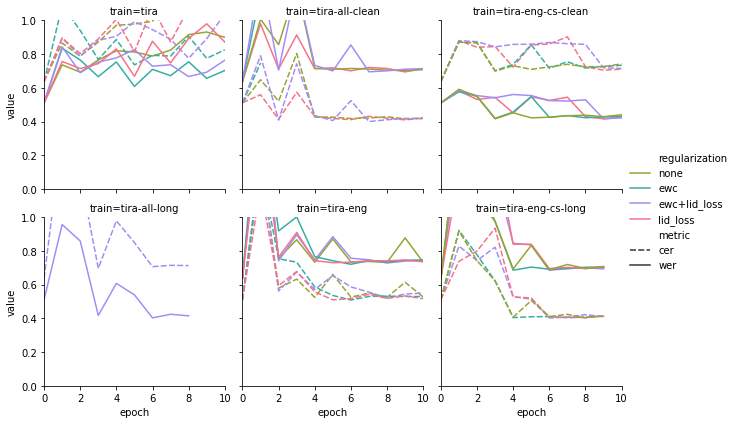

In [34]:
df['beam']=df['beam'].fillna(0).astype(float)
df['lm_alpha']=df['lm_alpha'].astype(str)
g = sb.FacetGrid(
    df[
        # (df['experiment_name'].str.contains('zulu')) &
        # ~(df['experiment_name'].str.contains('zulu-swahili-eng')) &
        (df['experiment_name'].str.contains('tira')) &
        (~df['train_data'].str.contains('20-80'))&
        (~df['train_data'].str.contains('misc'))&
        # (df['train_data'].str.contains('zulu-eng'))&
        (df['train_data']!='tira-all')&
        # (df['lang_prompt']=='swahili') &
        # (df['lang_prompt']=='croatian')&
        # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
        (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
        (df['ewc_lambda'].isin([0,1])) &
        (df['lid_loss_alpha'].isin([0,0.2])) &
        # (df['beam']==2)&
        (df['beam']==0)&
        # (df['regularization']=='none')&
        # (df['tag'].str.contains('loss'))
        # (df['tag']=='train/loss')
        (df['metric']!='')
        # (df['LoRA'])
    ],
    # col='ewc_lambda',
    col='train_data',
    col_wrap=3,
    # row='lm_alpha',
    # col='lid_loss_alpha',
    # row='beam',
    # row='dataset',
    # sharey=False,
)
palette_map= {
    key: color for key, color in
    zip(['lid_loss', 'none', 'ewc', 'ewc+lid_loss'], sb.color_palette('husl',4))
}
g.map_dataframe(
    sb.lineplot,
    x='epoch',
    # x='step',
    y='value',
    # y='loss_diff',
    # hue='lid_loss_alpha',
    hue='regularization',
    palette=palette_map,
    # hue='ewc_lambda',
    # errorbar=None,
    legend='full',
    style='metric',
    # style='tag',
)
# g.set_titles('eval={row_name}, train={col_name}')
g.set_titles('train={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
g.set(xlim=(0,10))
plt.show()

In [35]:
df.loc[df['experiment_name']=='whisper-small-tira-ewc-lambda-1','metric'].unique()

array(['cer', '', 'wer'], dtype=object)

In [36]:
zero_as_baseline = df.copy()
zero_as_baseline.loc[(df['epoch']==0)&(df['train_data'].str.contains('tira')),'train_data']='tira baseline'
zero_as_baseline.loc[(df['epoch']==0)&(df['train_data'].str.contains('zulu')),'train_data']='zulu baseline'
metric_cols = zero_as_baseline[
    (df['metric']!='')&
    (df['epoch']<=10)&
    # (df['epoch']>1)&
    (~df['train_data'].str.contains('20-80'))&
    (df['train_data']!='tira-all')&
    (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
    (~df['train_data'].str.contains('misc'))
].pivot_table(
    columns=['regularization'],
    values=['value'],
    index=['train_data', 'epoch', 'metric'],
    aggfunc=lambda x:x.min(),
).pivot_table(
    index=['train_data', 'epoch'],
    columns=['metric'],
).droplevel(
    axis=1,
    level=0
)
reg_names = ['none', 'ewc', 'lid_loss', 'ewc+lid_loss']
reg_dfs = []
for reg in reg_names:
    reg_df=metric_cols[reg]
    reg_df=reg_df.sort_values('wer')
    reg_df=reg_df.reset_index()
    reg_df=reg_df.rename_axis('', axis=1)
    # reg_df=reg_df[reg_df['epoch']>0]
    reg_df=reg_df.drop_duplicates(subset=['train_data'], keep='first')
    reg_df['regularization']=reg
    reg_dfs.append(reg_df)
reg_dfs = pd.concat(reg_dfs)
table=reg_dfs.melt(
    value_vars=['cer', 'wer', 'epoch'],
    var_name='var',
    id_vars=['train_data', 'regularization']
).sort_values(
    'train_data'
).pivot_table(
    columns=['regularization', 'var'],
    index='train_data'
)
table.columns.names=[None,'regularization',None]
table=table.droplevel(0,axis=1)
table=table.reset_index()
is_tira=table['train_data'].str.contains('tira')
table = pd.concat({'Tira': table[is_tira], 'Zulu': table[~is_tira]})
table=table.rename({
    'ewc': 'EWC',
    'lid_loss': 'LID loss',
    'none': 'Plain finetune',
    'ewc+lid_loss': 'EWC+LID loss',
    'train_data': 'Train dataset',
}, axis=1)
table['Train dataset']=table['Train dataset'].map({
    'tira': 'Mono',
    'tira-all-clean': 'All (short)',
    'tira-all-long': 'All (long)',
    'tira-eng': 'Biling',
    'tira-eng-cs-clean': "CS",
    'tira baseline': 'Baseline',
    'zulu': "Mono",
    'zulu+eng': "Biling",
    'zulu+eng-50pct': "Biling (50\\%)",
    'zulu-eng-all': 'All',
    'zulu-eng-cs': 'CS',
    'zulu baseline': 'Baseline',
})

for column in table.columns:
    if column[1]=='epoch':
        table[column]=table[column].astype(int)
    elif column[1]=='':
        pass
    elif column[1] in ('wer', 'cer'):
        table[column]=table[column].apply(lambda n:f"{n:.2f}")
for language in ['Tira', 'Zulu']:
    for column in table.columns:
        if column[1] in ('wer', 'cer'):
            min_idx = table.loc[language,column].astype(float).idxmin()
            min_val = table.at[(language,min_idx),column]
            table.loc[table[column]==min_val,column]=r'\textbf{'+min_val+r'}'
split_bf = lambda s:s.removeprefix(r'\textbf{').removesuffix(r'}')
def italicize_min_per_row(row):
    if row['Train dataset'].item() == 'Baseline':
        return row
    cer = row.index.get_level_values(1)=='cer'
    min_cer_idx = row[cer].apply(split_bf).astype(float).idxmin()
    min_cer_value=row[min_cer_idx]
    row[cer&(row==min_cer_value)]=r'\textit{'+min_cer_value+r'}'

    wer = row.index.get_level_values(1)=='wer'
    min_wer_idx = row[wer].apply(split_bf).astype(float).idxmin()
    min_wer_value=row[min_wer_idx]
    row[wer&(row==min_wer_value)]=r'\textit{'+min_wer_value+r'}'
    return row
table=table.apply(italicize_min_per_row, axis=1)
table=table.loc[:,table.columns.get_level_values(1)!='epoch']
table=pd.concat({
    'Tira':table.loc['Tira'].set_index('Train dataset'),
    'Zulu':table.loc['Zulu'].set_index('Train dataset'),
})
table.columns.names=None,None
ordered_cols = []
for reg in ['Plain finetune', 'EWC', 'LID loss', 'EWC+LID loss']:
    for metric in ['wer', 'cer']:
        ordered_cols.append((reg,metric))
table=table[ordered_cols]
ordered_rows = []
for ds in ['Baseline', 'Mono', 'Biling', 'CS', 'All (short)', 'All (long)']:
    ordered_rows.append(('Tira', ds))
for ds in ['Baseline', 'Mono', 'Biling', 'Biling (50\%)', 'CS', 'All']:
    ordered_rows.append(('Zulu', ds))
table=table.loc[ordered_rows]
table

Plain finetune                          \
                                       wer                     cer   
     Train dataset                                                   
Tira Baseline                \textbf{0.64}                    0.51   
     Mono                             0.79                    0.69   
     Biling                           0.73                    0.53   
     CS                      \textit{0.70}           \textit{0.42}   
     All (short)                      0.70                    0.42   
     All (long)                        nan                     nan   
Zulu Baseline                         1.49                    0.92   
     Mono                             0.86                    0.47   
     Biling                           0.59                    0.29   
     Biling (50\%)                    0.63                    0.36   
     CS                               0.48                    0.23   
     All            \textit{\textbf{0.41}}  \textit{\textbf{0.18}}   

                              EWC                      LID loss  \
                              wer            cer            wer   
     Train dataset                                                
Tira Baseline       \textbf{0.64}           0.51  \textbf{0.64}   
     Mono           \textit{0.74}  \textit{0.61}           0.80   
     Biling         \textit{0.72}  \textit{0.51}           0.73   
     CS             \textit{0.70}  \textit{0.42}  \textit{0.70}   
     All (short)             1.17           0.75  \textit{0.69}   
     All (long)               nan            nan            nan   
Zulu Baseline                1.49           0.92           1.49   
     Mono           \textit{0.69}  \textit{0.34}           0.70   
     Biling                  0.71           0.39           0.57   
     Biling (50\%)           0.63           0.35  \textit{0.62}   
     CS             \textit{0.47}  \textit{0.22}           0.48   
     All            \textbf{0.42}  \textbf{0.19}  \textbf{0.42}   

                                             EWC+LID loss  \
                                       cer            wer   
     Train dataset                                          
Tira Baseline                         0.51  \textbf{0.64}   
     Mono                             0.71           0.78   
     Biling                  \textit{0.51}           0.73   
     CS                      \textit{0.42}           0.71   
     All (short)                      0.41           0.70   
     All (long)                        nan  \textit{0.70}   
Zulu Baseline                         0.92           1.49   
     Mono                    \textit{0.34}           0.70   
     Biling                  \textit{0.27}  \textit{0.55}   
     Biling (50\%)           \textit{0.33}  \textit{0.62}   
     CS                               0.27           0.50   
     All            \textit{\textbf{0.18}}  \textbf{0.42}   

                                            
                                       cer  
     Train dataset                          
Tira Baseline                         0.51  
     Mono                             0.67  
     Biling                           0.52  
     CS                      \textit{0.42}  
     All (short)    \textit{\textbf{0.40}}  
     All (long)              \textit{0.42}  
Zulu Baseline                         0.92  
     Mono                             0.35  
     Biling                  \textit{0.27}  
     Biling (50\%)           \textit{0.33}  
     CS                               0.23  
     All                     \textbf{0.19}

In [37]:
with open('table.tex', 'w') as f:
    latex_str=table.to_latex(index=True, escape=False, sparsify=True, multirow=False)
    latex_str=latex_str.replace(r'\multicolumn{2}{r}', r'\multicolumn{2}{l}')
    latex_str=latex_str.replace('Zulu','\midrule\nisiZulu')
    f.write(latex_str)

# Lang specific metrics

In [38]:
df['tag'].unique()

array(['eval/tira_eval-en+sw_cer', 'eval/tira_eval-en+sw_wer',
       'eval/fl_en-en_samples_per_second',
       'eval/tira_eval-en+sw_steps_per_second',
       'eval/tira_eval-en+sw_samples_per_second', 'train/epoch',
       'eval/tira_eval-en+sw_runtime', 'eval/tira_eval-en+sw_loss',
       'eval/fl_en-en_steps_per_second', 'eval/fl_en-en_wer',
       'eval/sasoc-cs-en+sw_steps_per_second', 'eval/sasoc-cs-en+sw_cer',
       'eval/sasoc-cs-en+sw_wer', 'eval/fl_en-en_runtime',
       'eval/sasoc-cs-en+sw_samples_per_second',
       'eval/sasoc-cs-en+sw_loss', 'eval/samples_per_second',
       'eval/steps_per_second', 'eval/wer', 'eval/sasoc-cs-en+sw_runtime',
       'eval/fl_en-en_loss', 'eval/runtime', 'eval/fl_en-en_cer',
       'eval/cer', 'eval/loss', 'eval/nchlt_zul_val-sw_steps_per_second',
       'eval/nchlt_zul_val-sw_wer', 'eval/nchlt_zul_val-sw_loss',
       'eval/nchlt_zul_val-sw_runtime',
       'eval/nchlt_zul_val-sw_samples_per_second',
       'eval/nchlt_zul_val-sw_cer',